In [ ]:
# loading libraries
import numpy as np
import pandas as pd
import requests
import time

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance


# processing data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# regression models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor

# score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

# date transforming
from datetime import datetime
import datetime as dt

# xgboost
from xgboost import XGBClassifier, XGBRegressor

# tqdm
from tqdm import tqdm

In [ ]:
# api information
api_key = '#'
BASE_URL = "https://api.balldontlie.io/v1"
headers = {"Authorization": api_key}

In [ ]:
# this will write a function that we get all endpoints from this function so the error will be easy to see
def api_get(endpoint, params=None):
    url = f"{BASE_URL}/{endpoint}"
    r = requests.get(url, params=params, headers=headers)

    try:
        r.raise_for_status()
    except Exception as e:
        print("HTTP error:", r.status_code)
        print("Response:", r.text[:300])
        raise e

    try:
        return r.json()
    except:
        print("JSON decode error. Raw response:")
        print(r.text[:300])
        raise

In [ ]:
def feature_engineering(df):
    df = df.copy()

    # remove DNP games
    df = df[df["min"] > 0].copy()

    # sort by player + date
    df = df.sort_values(["player.id", "game.date"]).reset_index(drop=True)

    # rolling windows
    rolling_windows = [3, 5, 10]
    stats_cols = ["pts", "reb", "ast", "fg_pct", "min"]

    for w in rolling_windows:
        for col in stats_cols:
            df[f"{col}_last_{w}"] = (
                df.groupby("player.id")[col]
                  .rolling(w).mean().shift(1)
                  .reset_index(level=0, drop=True)
            )

    # simple shortcuts
    df["rolling_fg_pct_5"] = df["fg_pct_last_5"]
    df["rolling_minutes_5"] = df["min_last_5"]

    # season metrics
    df["pts_season_avg"] = df.groupby("player.id")["pts"].transform("mean")
    df["reb_season_avg"] = df.groupby("player.id")["reb"].transform("mean")
    df["ast_season_avg"] = df.groupby("player.id")["ast"].transform("mean")
    df["min_season_avg"] = df.groupby("player.id")["min"].transform("mean")

    df["pts_season_std"] = df.groupby("player.id")["pts"].transform("std").fillna(0)
    df["min_season_std"] = df.groupby("player.id")["min"].transform("std").fillna(0)

    # rest days
    df["prev_game_date"] = df.groupby("player.id")["game.date"].shift(1)
    df["rest_days"] = (df["game.date"] - df["prev_game_date"]).dt.days
    df["rest_days"] = df["rest_days"].fillna(df["rest_days"].median())

    # opponent id
    df["opponent_team_id"] = df.apply(
        lambda r: r["game.home_team_id"] if r["player.team_id"] != r["game.home_team_id"]
        else r["game.visitor_team_id"],
        axis=1
    )

    # APPROACH: build opponent rolling allowed stats fully leakage-free
    # we compute avg allowed points BEFORE each date
    opp_history = (
        df.groupby(["opponent_team_id", "game.date"])
          .agg(
              opp_pts_allowed=("pts", "sum"),
              opp_reb_allowed=("reb", "sum"),
              opp_ast_allowed=("ast", "sum"),
              opp_minutes=("min", "sum")
          )
          .reset_index()
          .sort_values(["opponent_team_id", "game.date"])
    )

    # rolling shift
    for w in [5, 10]:
        for col in ["opp_pts_allowed", "opp_reb_allowed", "opp_ast_allowed"]:
            opp_history[f"{col}_last_{w}"] = (
                opp_history.groupby("opponent_team_id")[col]
                .rolling(w).mean().shift(1)
                .reset_index(level=0, drop=True)
            )

    # merge back
    df = df.merge(
        opp_history,
        on=["opponent_team_id", "game.date"],
        how="left"
    )

    # pace estimation
    df["opp_pace_est"] = df["opp_minutes"] / 240

    # usage
    df["usage_basic"] = df["fga"] + df["fta"] + df["turnover"]

    df["usage_last_5"] = (
        df.groupby("player.id")["usage_basic"]
        .rolling(5).mean().shift(1)
        .reset_index(level=0, drop=True)
    )

    # supervised target
    df["next_pts"] = df.groupby("player.id")["pts"].shift(-1)

    df = df.dropna(subset=["next_pts"])
    return df

In [ ]:
def train_test_split_time(df, test_ratio=0.2):
    df = df.sort_values("game.date")
    split = int(len(df) * (1 - test_ratio))
    return df.iloc[:split], df.iloc[split:]

In [ ]:
def train_xgb(train_df, test_df, feature_cols):
    model = XGBRegressor(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    model.fit(train_df[feature_cols], train_df["next_pts"])

    preds = model.predict(test_df[feature_cols])

    rmse = np.sqrt(mean_squared_error(test_df["next_pts"], preds))
    print("XGB RMSE:", rmse)

    return model, preds

In [ ]:
def predict_player_next(model, df_feat, player_id, feature_cols):
    df_player = df_feat[df_feat["player.id"] == player_id]
    df_player = df_player.sort_values("game.date")

    latest_row = df_player.iloc[-1][feature_cols]
    pred = model.predict(latest_row.values.reshape(1, -1))[0]

    print(f"Predicted next-game points for player {player_id}: {pred:.2f}")
    return pred

In [ ]:
# clean raw API dataset
df_clean = pd.read_csv("raw_data.csv", parse_dates=["game.date"])

# feature engineering
df_feat = feature_engineering(df_clean)

# time split
train_df, test_df = train_test_split_time(df_feat)

# build feature columns
leak_cols = [
    "pts", "reb", "ast", "fgm", "fga", "fg3m", "fg3a",
    "ftm", "fta", "turnover", "oreb", "dreb", "blk", "stl", "pf"
]

problem_cols = [
    "game.date", "game.id", "player.id", "next_pts",
    "prev_game_date"
]

feature_cols = [
    c for c in df_feat.columns
    if c not in leak_cols
    and c not in problem_cols
    and df_feat[c].dtype in ["float64", "int64", "bool"]
]

# training model
xgb_model, xgb_preds = train_xgb(train_df, test_df, feature_cols)

# Curry example
predict_player_next(xgb_model, df_feat, player_id=115, feature_cols=feature_cols)

XGB RMSE: 6.199807677180084
Predicted next-game points for player 115: 26.66


np.float32(26.663813)

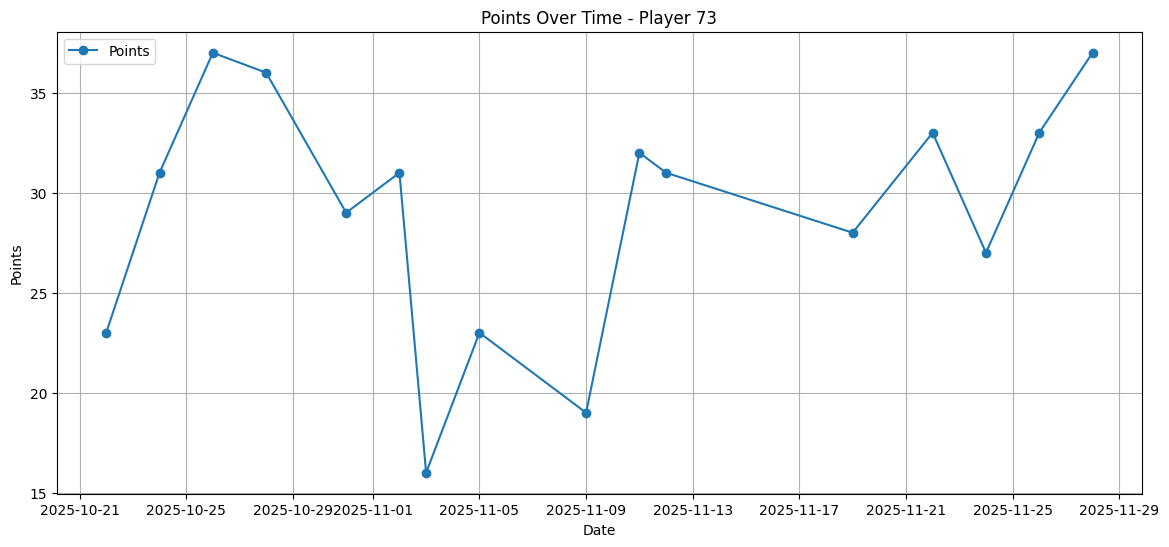

In [ ]:
# example of Stephan Curry: Real Points
def plot_player_points(df, player_id):
    dfp = df[df["player.id"] == player_id].sort_values("game.date")

    plt.figure(figsize=(14,6))
    plt.plot(dfp["game.date"], dfp["pts"], marker="o", label="Points")

    plt.title(f"Points Over Time - Player {player_id}")
    plt.xlabel("Date")
    plt.ylabel("Points")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_player_points(df_feat, 73)  # sga

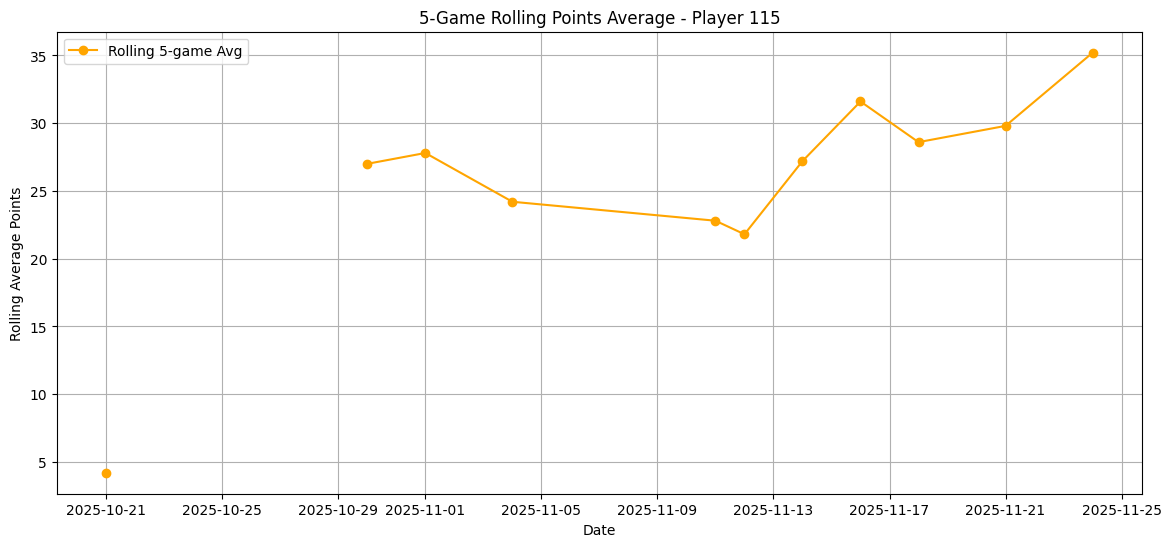

In [ ]:
# example of Giannis: Rolling Points
def plot_player_rolling(df, player_id, window=5):
    dfp = df[df["player.id"] == player_id].sort_values("game.date")

    plt.figure(figsize=(14,6))
    plt.plot(dfp["game.date"], dfp[f"pts_last_{window}"],
             marker="o", color="orange", label=f"Rolling {window}-game Avg")

    plt.title(f"{window}-Game Rolling Points Average - Player {player_id}")
    plt.xlabel("Date")
    plt.ylabel("Rolling Average Points")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_player_rolling(df_feat, 115, window=5)

<Figure size 1000x1800 with 0 Axes>

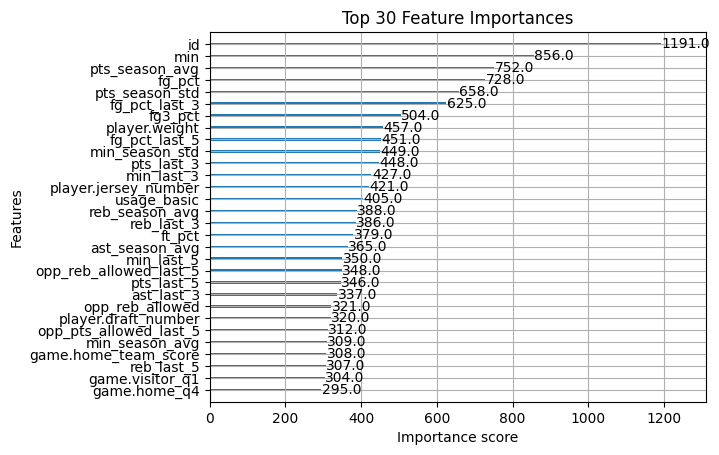

In [ ]:
# listing the significant data
plt.figure(figsize=(10,18))
plot_importance(xgb_model, max_num_features=30)
plt.title("Top 30 Feature Importances")
plt.show()

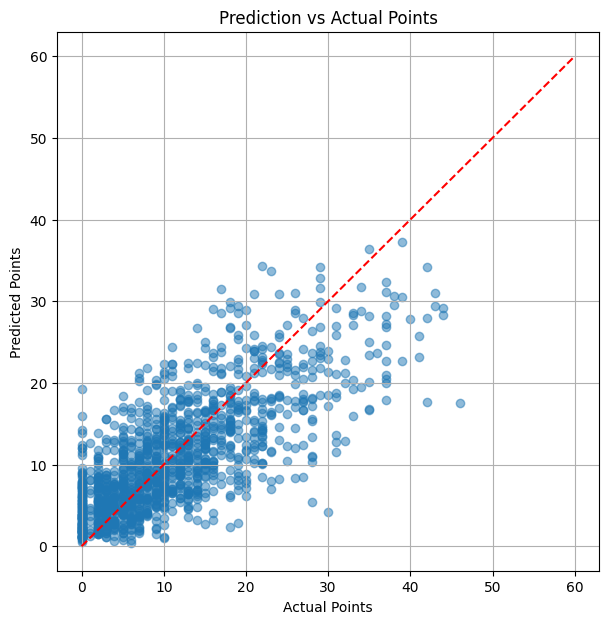

In [ ]:
# how close the prediction is to the real data (x=y)
def plot_pred_vs_actual(test_df, preds):
    plt.figure(figsize=(7,7))
    plt.scatter(test_df["next_pts"], preds, alpha=0.5)
    plt.plot([0,60],[0,60], color="red", linestyle="--")

    plt.title("Prediction vs Actual Points")
    plt.xlabel("Actual Points")
    plt.ylabel("Predicted Points")
    plt.grid(True)
    plt.show()

plot_pred_vs_actual(test_df, xgb_preds)

In [ ]:
# which players model is not good at
test_df["error"] = xgb_preds - test_df["next_pts"]
player_error = test_df.groupby("player.id")["error"].mean().sort_values()

print(player_error.head(10))   # lower than real
print(player_error.tail(10))  # higher than real

player.id
666849       -12.790632
17896045     -11.635907
3547246      -10.884261
117          -10.778463
1057279571   -10.391449
303          -10.073448
475           -9.710747
1028255289    -9.696713
56677839      -9.585803
666950        -9.039380
Name: error, dtype: float64
player.id
666604         6.655932
38017686       6.738296
1028240128     6.955690
1057266649     7.053621
387            7.133324
283            7.178162
1028026060     9.772279
38017696      12.008519
115           12.663813
38017690      13.239267
Name: error, dtype: float64


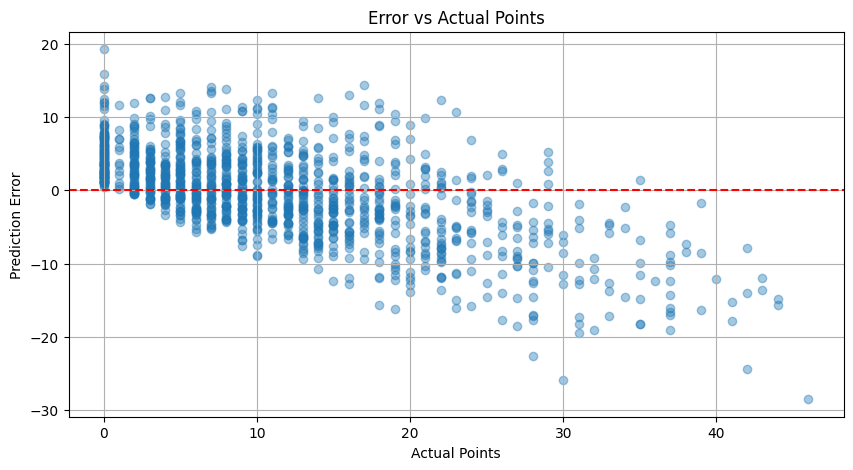

In [ ]:
# is harder to predict when the score is higher
plt.figure(figsize=(10,5))
plt.scatter(test_df["next_pts"], test_df["error"], alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Actual Points")
plt.ylabel("Prediction Error")
plt.title("Error vs Actual Points")
plt.grid(True)
plt.show()

In [ ]:
# prediction of Giannis next game（ the next game after 12-01 was 12-02 he scored 15 and 12-03 he scored 26
predict_player_next(xgb_model, df_feat, player_id=73, feature_cols=feature_cols)

Predicted next-game points for player 73: 26.74


np.float32(26.741858)